<a href="https://colab.research.google.com/github/Sarvesh1814/rag-llm-specialization-roadmap/blob/main/Phase-1%20RAG%20Foundations%20/Theory/01_FAISS_Basics_and_Beyond_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to FAISS

## What is FAISS?



FAISS stands for **F**acebook **A**rtificial **I**ntelligence **S**imilarity **S**earch.

It is a library for efficient similarity search and clustering of dense vectors. This library has one of the advance searching algorithms which are implemented using C++ and some of them utilises CPU however the most useful ones are implemented on GPU.

Given a set of vectors
{
x
1
,
.
.
.
,
x
n
}
 in dimension
d
, Faiss builds a data structure in RAM. After the structure is constructed, when given a new vector
x
 in dimension
d
 it performs efficiently the operation:

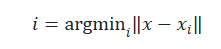

where
‖
.
‖
 is the Euclidean distance (L2).

In Faiss terms, the data structure is an index, an object that has an add method to add x_i vector. Note that the dimension of x_i is assumed to be fixed.

Computing the argmin is the search operation on the index.

## Installing FAISS

### FAISS CPU

**FAISS CPU Requirements**

* Basic — works on most environments.

* Python: 3.7 – 3.12 (depends on pip wheel availability)

* OS: Linux, macOS, Windows (Windows wheels for CPU only)

* Pip / Conda: Latest version recommended

* RAM: Enough to hold your dataset in memory (FAISS is RAM-bound for CPU)



**Command to Install FAISS-CPU**

pip install faiss-cpu


### FAISS GPU

**FAISS GPU Requirements**

* Extra requirements for GPU acceleration:

* Python: 3.7 – 3.12

* OS: Linux (GPU pip wheels are officially Linux-only — on Windows you need WSL or build from source)

* CUDA Toolkit: Version 11.x or 12.x (match with your NVIDIA driver)

* NVIDIA Driver: Compatible with the chosen CUDA version (e.g., CUDA 12.x requires NVIDIA driver ≥ 525)

* GPU Memory: At least 4 GB VRAM for small datasets (more for large datasets)

* Pip / Conda: Latest version recommended

**Command to Install FAISS-GPU**

pip install faiss-gpu

# Getting Started with FAISS


## Understanding the basics of FAISS


FAISS is able to handle the collection of vectors of a fixed dimensionality d (typically between multiple of 10 and 100).

* It assumes that the embedding matrix is of shape n x d (Row-major storage) where n is no of words/sentence/document and d is embedding dimensions.

e.g

|Index     |D1 |D2 |D3 |D4 |
|:---------|:---------:|------:|------:|------:|
| CT1    | 0.1 |   0.95|   0.15|   0.46|
| CT2  | 0.5 |   0.77|   0.01|   0.97|
| CT3   | 0.8 |   0.91|   0.07|   0.01|

Here,

CT = Context Text (This can be a character/word/sentence/document)
D = Dimension

* The FAISS uses only 32-bit floating point matrice.

## Understanding Indexing and Searching


### Indexing

1. FAISS is built around the Index object.
2. It encapsulates the set of database vectors.
3. It can also preporcess the database vectors to make search efficient. (optional)

When an FAISS index is created they operate on the dimensionality of the vectors (D). Most of the indices requires the training phase to understand the distribution of the vectors.

When an index is built and trained after that two operations can be performed on it: **add** and **search**

Some of the indices can store the integer IDs corresponding to the each of the vectors and if IDs are not provided it assigns the id from 0,1,... n-1.


### Types of Indexes


**Basic Indexes**

| Method                                     | Class name              | index_factory         | Main parameters                            | Bytes/vector                           | Exhaustive | Comments                                                                                       | When useful                                                                 |
|--------------------------------------------|--------------------------|-----------------------|--------------------------------------------|-----------------------------------------|------------|------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------|
| Exact Search for L2                        | IndexFlatL2             | "Flat"                | d                                          | 4*d                                     | yes        | brute-force                                                                                   | Small datasets, need exact L2 distance                                      |
| Exact Search for Inner Product             | IndexFlatIP             | "Flat"                | d                                          | 4*d                                     | yes        | also for cosine (normalize vectors beforehand)                                                 | Small datasets, cosine similarity or inner product search                   |
| Hierarchical Navigable Small World graph   | IndexHNSWFlat           | "HNSW,Flat"           | d, M                                       | 4*d + x * M * 2 * 4                     | no         | graph-based ANN                                                                                 | Large-scale datasets needing high recall + fast queries                     |
| Inverted file with exact post-verification | IndexIVFFlat            | "IVFx,Flat"           | quantizer, d, nlists, metric               | 4*d + 8                                 | no         | uses another index to assign vectors to inverted lists                                         | Medium/large datasets, speedup over brute force while keeping accuracy       |
| Locality-Sensitive Hashing (binary flat)   | IndexLSH                | -                     | d, nbits                                   | ceil(nbits/8)                           | yes        | optimized with random rotation                                                                | Very high-dimensional data, quick approximate filtering                     |
| Scalar quantizer (SQ) in flat mode         | IndexScalarQuantizer    | "SQ8"                 | d                                          | d                                       | yes        | 4 and 6 bits per component are also implemented                                                | When memory is limited but accuracy must be preserved reasonably             |
| Product quantizer (PQ) in flat mode        | IndexPQ                 | "PQx","PQ"M"x"nbits   | d, M, nbits                                | ceil(M * nbits / 8)                     | yes        | codebook-based compression                                                                     | Large datasets where memory reduction is critical                            |
| IVF + Scalar quantizer                     | IndexIVFScalarQuantizer | "IVFx,SQ4" "IVFx,SQ8" | quantizer, d, nlists, qtype                | SQfp16: 2*d+8, SQ8: d+8, SQ4: d/2+8     | no         | same as SQ but with IVF partitioning                                                           | Large-scale datasets with tighter memory constraints                        |
| IVFADC (coarse quantizer + PQ on residuals)| IndexIVFPQ              | "IVFx,PQy"x"nbits"    | quantizer, d, nlists, M, nbits             | ceil(M*nbits/8)+8                       | no         | PQ applied on residuals after IVF                                                             | Good trade-off between memory and accuracy on very large datasets            |
| IVFADC+R (IVFADC with re-ranking)          | IndexIVFPQR             | "IVFx,PQy+z"          | quantizer, d, nlists, M, nbits, M_refine… | M+M_refine+8                            | no         | same as IVFADC but improves ranking accuracy using refinement                                   | When you need both scalability and improved accuracy after initial ANN search|



#### Flat Indexes

##### IndexFlatL2 and IndexFlatIP
In Flat indexes, the vectors are encoded into codes of a fixed size and store them in an arry of ntotal * code_size bytes.

At the search time, all the indexed vectors are decoded sequentially and compared to the query vectors. To make the comparision faster, in IndexPQ the it is done in compressed domain.

**Flat Index Characterstics:**

1. They don't support add_with_id
2. They do support efficient direct vector access.
3. They support removal with remove. But after that the index shrinks and changes the numbering.

As mentioned above, the vectors are encoded into code of fix sizes. Belowlisted are the available encodings:

* **No Encoding**
* **16-bit Float Encoding**
* **8/6/4-bit Integer Encoding** (Quantizing the vectors to 256/64/16 levels)
* **PQ Encoding** (Here the vectors are splitted into sub-vectors and then they are Quantized further)
* **Residual Encoding** : the vectors are quantized and progressively refined by residual. At each quantization stage, the size of the codebook can be redefined.



###### **Understanding Residual Encoding with an example**

Imagine you want to describe a house 🏠 to someone, but you can’t send a photo (too much data).

You need to describe it in compressed steps:

1. (First rough sketch / coarse quantizer):
You say, “It’s a two-story house with a red roof.”
→ This gives a rough idea, but not the full details.

2. (Residual quantization / correction):
Then you refine it by adding what’s missing:
“Also, the windows are big and rectangular.”
→ This corrects/adjusts the previous rough sketch.

3. (Further refinement):
You keep adding residual details:
“There’s a small porch at the front.”
“The door is white.”

By the end, the person has a progressively refined description that gets closer and closer to the real image of the house.

**How this works in FAISS:**

Instead of describing houses, FAISS is storing vectors (embeddings).

A vector (say, 512 numbers from an embedding model) is too large to store directly.

FAISS uses quantizers to compress it:

First quantizer = a rough approximation of the vector.

Compute the residual = (original vector – approximation).

Second quantizer encodes that residual.

Repeat the process, each stage refining the leftover error.

So the final stored code is a chain of approximations, where each stage fixes the mistakes of the previous one.

**Plain takeaway:**

Residual encoding is like iteratively refining a rough sketch into a detailed drawing.

First pass = rough idea.

Each residual = adds missing details.

Result = efficient compression with better accuracy than one-shot quantization.

**Formulation**

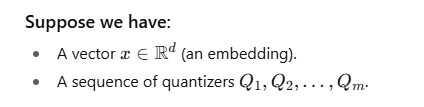
---
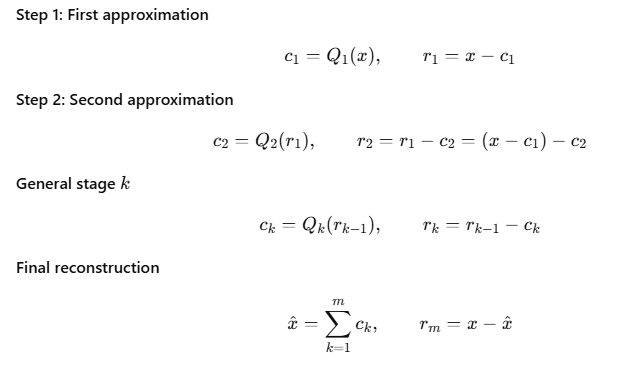

## Intuition

- Each \(c_k\) is a **correction vector** that fixes the error left by previous quantizers.  
- \(\hat{x}\) is the reconstructed approximation of the original vector.  
- As more stages are added, the error \(r_m\) becomes smaller.  

✅ **Why it's useful:** Instead of one huge codebook (memory-heavy), you use smaller quantizers in sequence. This balances **compression** and **accuracy**.

##### IndexIVF

This is a way where we have trade-off between Speed and Accuracy. In this approach the accuracy is traded off with speed.

In this method the feature space is partitioned into nlist cells. The databse vectores are assigned to one of these cells using a quantization function and stored in an inverted file structre formed of nlist inverted lists.

During the search, the query is compared to each of the database vector assinged to these list but this will be just an approximation as these vectors won't be of equal size.


##### IndexHNSW variants

The Hierarchical Navigable Small World indexing method is based on a graph built on the indexed vectors. At search time, the graph is explored in a way that converges to the nearest neighbors as quickly as possible. The IndexHNSW uses a flat index as underlying storage to quickly access the database vectors and abstract the compression / decompression of vectors. HNSW depends on a few important parameters:

* **M** is the number of neighbors used in the graph. A larger M is more accurate but uses more memory

* **efConstruction** is the depth of exploration at add time

* **efSearch** is the depth of exploration of the search

*Supported encodings*

IndexHNSW supports the following Flat indexes: IndexHNSWFlat (no encoding), IndexHNSWSQ (scalar quantizer), IndexHNSWPQ (product quantizer), IndexHNSW2Level (two-level encoding).

#### Binary Indexes

### Searching


The basic search operation that can be performed on an index is K-nearest neighbour.

This will provide us the matrix of size nq x k.

        nq = no of queries

The result of this search depends on how better the embeddings are.